# Introduction to Neural Networks 
Author: Bethany Lusch, adapting materials from Marieme Ngom, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset. 

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

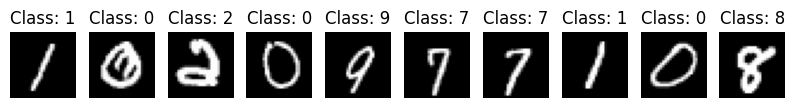

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [6]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week. 
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication. 

Note, like before, we consider multiple examples at once, adding another dimension to the input. 


 <img src="images/LinearModel_1.png"  align="center"/>
 


The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. 

We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

Let's make two changes that make more sense for classification:
- Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
- Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

In [7]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        # print("dim x after flatten = ", x.shape)
        x = self.layer_1(x)
        # print("dim x for layer = ", x.shape)

        return x

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this time we're switching to cross entropy since it's classification.  

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step. 

In [8]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.9046070777575175, accuracy: 83.32916666666667
Epoch 1: training loss: 0.6787430922190348, accuracy: 85.46666666666667
Epoch 2: training loss: 0.5863989593982697, accuracy: 86.46458333333334
Epoch 3: training loss: 0.5344216776688894, accuracy: 87.1375
Epoch 4: training loss: 0.5003328187465668, accuracy: 87.58749999999999
CPU times: user 18min 21s, sys: 22.6 s, total: 18min 44s
Wall time: 35.7 s


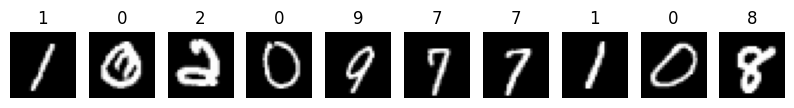

In [12]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc. 

## Increase number of epochs

In [44]:
%%time

epochs = 15
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.47751225884755455, accuracy: 87.9625
Epoch 1: training loss: 0.4587046173413595, accuracy: 88.2125
Epoch 2: training loss: 0.4437882155577342, accuracy: 88.47083333333333
Epoch 3: training loss: 0.43158716773986816, accuracy: 88.7
Epoch 4: training loss: 0.4213669209480286, accuracy: 88.925
Epoch 5: training loss: 0.41264273635546367, accuracy: 89.11666666666666
Epoch 6: training loss: 0.4050805512269338, accuracy: 89.24791666666667
Epoch 7: training loss: 0.3984418741861979, accuracy: 89.39791666666666
Epoch 8: training loss: 0.39255139966805774, accuracy: 89.48958333333333
Epoch 9: training loss: 0.38727707958221436, accuracy: 89.59583333333333
Epoch 10: training loss: 0.38251730807622275, accuracy: 89.725
Epoch 11: training loss: 0.3781924975713094, accuracy: 89.82083333333334
Epoch 12: training loss: 0.37423932246367136, accuracy: 89.92916666666667
Epoch 13: training loss: 0.3706066663662593, accuracy: 90.01666666666667
Epoch 14: training loss: 0.367252760

## Smaller learning rate

In [32]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.001)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


In [33]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 1.9409710315068562, accuracy: 60.791666666666664
Epoch 1: training loss: 1.6852606779734294, accuracy: 72.54791666666667
Epoch 2: training loss: 1.4911285127003988, accuracy: 76.19791666666667
Epoch 3: training loss: 1.3425885101954143, accuracy: 78.125
Epoch 4: training loss: 1.227133721669515, accuracy: 79.43333333333334
CPU times: user 18min 46s, sys: 22.5 s, total: 19min 8s
Wall time: 35.9 s


## Higher learning rate

In [34]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.1)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


In [35]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.42328088625272114, accuracy: 88.88333333333334
Epoch 1: training loss: 0.36926116518179575, accuracy: 90.04166666666666
Epoch 2: training loss: 0.3455421834786733, accuracy: 90.63333333333333
Epoch 3: training loss: 0.3313069945971171, accuracy: 90.93333333333334
Epoch 4: training loss: 0.3214999365409215, accuracy: 91.15625
CPU times: user 18min 46s, sys: 22.6 s, total: 19min 8s
Wall time: 35.9 s


## Smaller batch size

In [45]:
batch_size = 64

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [46]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


In [47]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.6839861320654551, accuracy: 85.27708333333334
Epoch 1: training loss: 0.5378040062586467, accuracy: 87.05416666666666
Epoch 2: training loss: 0.4784145955840747, accuracy: 87.9625
Epoch 3: training loss: 0.4445433569351832, accuracy: 88.54375
Epoch 4: training loss: 0.4220131072004636, accuracy: 88.99583333333332
CPU times: user 19min 22s, sys: 23 s, total: 19min 45s
Wall time: 37.1 s


# Inference

For a better measure of the quality of the model, let's see the model accuracy for the validation data.



In [13]:
acc_val, loss_val = evaluate(val_dataloader, linear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.4934, validation accuracy: 87.62%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [14]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the validation data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


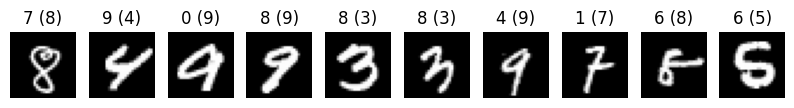

In [15]:
show_failures(linear_model, val_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn.png"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>

To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [17]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

# Homework: train a Nonlinear Classifier

1. Write some code to train the NonlinearClassifier.
2. Create a data loader for the test data and check your model's accuracy on the test data. 

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

## 1.

In [18]:
Nonlinear_model = NonlinearClassifier()
print(Nonlinear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Nonlinear_model.parameters(), lr=0.01)

NonlinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [19]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, Nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, Nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 2.102836924235026, accuracy: 27.900000000000002
Epoch 1: training loss: 1.2569202213287354, accuracy: 74.77083333333333
Epoch 2: training loss: 0.6941441961924235, accuracy: 82.74583333333332
Epoch 3: training loss: 0.5303875311215719, accuracy: 85.91666666666666
Epoch 4: training loss: 0.4576983652909597, accuracy: 87.47291666666666
CPU times: user 18min 38s, sys: 21.6 s, total: 18min 59s
Wall time: 35.6 s


## 2.

In [21]:
# test_data = torchvision.datasets.MNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=torchvision.transforms.ToTensor()
# )

In [20]:
batch_size = 128

# The dataloader makes our dataset iterable 
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [22]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(test_dataloader, Nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(test_dataloader, Nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.4254197433968134, accuracy: 88.27000000000001
Epoch 1: training loss: 0.41381428164394596, accuracy: 88.48
Epoch 2: training loss: 0.40360330705401265, accuracy: 88.72
Epoch 3: training loss: 0.39443125707816473, accuracy: 88.94
Epoch 4: training loss: 0.38619898231346395, accuracy: 89.11
CPU times: user 3min 55s, sys: 4.29 s, total: 3min 59s
Wall time: 7.5 s


## Improve model

### Increase number of epochs

In [26]:
%%time

epochs = 15
for j in range(epochs):
    train_one_epoch(train_dataloader, Nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, Nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.32953737409909567, accuracy: 90.77916666666667
Epoch 1: training loss: 0.31839810287952425, accuracy: 91.11666666666667
Epoch 2: training loss: 0.3095270007054011, accuracy: 91.31875000000001
Epoch 3: training loss: 0.301787916580836, accuracy: 91.55416666666667
Epoch 4: training loss: 0.2947682523727417, accuracy: 91.72916666666666
Epoch 5: training loss: 0.2882519790728887, accuracy: 91.86666666666666
Epoch 6: training loss: 0.2821593150695165, accuracy: 92.01666666666667
Epoch 7: training loss: 0.2764284380674362, accuracy: 92.16041666666666
Epoch 8: training loss: 0.2709571268558502, accuracy: 92.29791666666667
Epoch 9: training loss: 0.2656388501326243, accuracy: 92.47916666666667
Epoch 10: training loss: 0.2605225289861361, accuracy: 92.60833333333333
Epoch 11: training loss: 0.25556408806641895, accuracy: 92.71875
Epoch 12: training loss: 0.25074480565388996, accuracy: 92.83958333333334
Epoch 13: training loss: 0.24607448917627334, accuracy: 92.98958333

In [27]:
acc_val, loss_val = evaluate(val_dataloader, Nonlinear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.2354, validation accuracy: 93.14%


In [28]:
%%time

epochs = 15
for j in range(epochs):
    train_one_epoch(test_dataloader, Nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(test_dataloader, Nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.22423132307305457, accuracy: 93.39
Epoch 1: training loss: 0.21738617341656974, accuracy: 93.61
Epoch 2: training loss: 0.21201752294092233, accuracy: 93.73
Epoch 3: training loss: 0.20745161450379024, accuracy: 93.91000000000001
Epoch 4: training loss: 0.20330622725805658, accuracy: 94.01
Epoch 5: training loss: 0.19945354992820388, accuracy: 94.22
Epoch 6: training loss: 0.19577247564010558, accuracy: 94.25
Epoch 7: training loss: 0.19233016819236384, accuracy: 94.34
Epoch 8: training loss: 0.18896029133847944, accuracy: 94.46
Epoch 9: training loss: 0.18576423763327157, accuracy: 94.54
Epoch 10: training loss: 0.18254394974013802, accuracy: 94.66
Epoch 11: training loss: 0.17951230859609357, accuracy: 94.74000000000001
Epoch 12: training loss: 0.17657454092364022, accuracy: 94.91000000000001
Epoch 13: training loss: 0.17365485280277623, accuracy: 95.0
Epoch 14: training loss: 0.17083201255459504, accuracy: 95.06
CPU times: user 11min 41s, sys: 14.1 s, total

### Decrease batch size

In [29]:
batch_size = 64

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Nonlinear_model.parameters(), lr=0.01)

In [31]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, Nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, Nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.21789027148485185, accuracy: 93.74791666666667
Epoch 1: training loss: 0.2074642181098461, accuracy: 94.08125000000001
Epoch 2: training loss: 0.1988109363913536, accuracy: 94.32916666666667
Epoch 3: training loss: 0.1910870904525121, accuracy: 94.58333333333333
Epoch 4: training loss: 0.18413348970313867, accuracy: 94.78750000000001
CPU times: user 19min 17s, sys: 22.3 s, total: 19min 40s
Wall time: 36.9 s


In [32]:
batch_size = 64

# The dataloader makes our dataset iterable 
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [33]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(test_dataloader, Nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(test_dataloader, Nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.1518384532196222, accuracy: 95.61
Epoch 1: training loss: 0.14691262950551262, accuracy: 95.73
Epoch 2: training loss: 0.14311321919997502, accuracy: 95.89999999999999
Epoch 3: training loss: 0.13980585889546734, accuracy: 96.00999999999999
Epoch 4: training loss: 0.1367596231822138, accuracy: 96.08
CPU times: user 3min 53s, sys: 4.77 s, total: 3min 57s
Wall time: 7.43 s


### Increase learning rate

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Nonlinear_model.parameters(), lr=0.1)

In [35]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, Nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, Nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.15920126371085644, accuracy: 95.46666666666667
Epoch 1: training loss: 0.12853596311807633, accuracy: 96.29375
Epoch 2: training loss: 0.1076511093005538, accuracy: 96.88125
Epoch 3: training loss: 0.09533470027645428, accuracy: 97.25416666666666
Epoch 4: training loss: 0.08243955874567231, accuracy: 97.59166666666667
CPU times: user 18min 37s, sys: 21.4 s, total: 18min 59s
Wall time: 35.6 s


In [36]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(test_dataloader, Nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(test_dataloader, Nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.07835107304565134, accuracy: 97.64
Epoch 1: training loss: 0.061487657814746376, accuracy: 98.13
Epoch 2: training loss: 0.05062198082384042, accuracy: 98.49
Epoch 3: training loss: 0.042449992039770325, accuracy: 98.83999999999999
Epoch 4: training loss: 0.03585904956666255, accuracy: 99.02
CPU times: user 3min 55s, sys: 4.48 s, total: 3min 59s
Wall time: 7.5 s


# JupyterHub Reminder

From [Homework 0](https://github.com/argonne-lcf/ai-science-training-series/blob/main/00_introToAlcf/02_jupyterNotebooks.md): "If you simply close your browser window, or logout without shutting down the jupyter server, your job will continue to occupy the worker node. Be considerate and shutdown your job when you finish."

File --> Hub Control Panel --> Stop my server